# Stanford 40


In [88]:
import random
from collections import Counter
from PIL import Image, ImageEnhance, ImageOps
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import requests
import shutil
import patoolib
import glob
import numpy as np

# CNN
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchmetrics import Accuracy
from torchinfo import summary
from tqdm.notebook import tqdm

DOWNLOAD_STANFORD40 = False 
DOWNLOAD_HMDB51 = False

stanford_images_path = "Stanford40/JPEGImages"

### Download the data

In [ ]:
if DOWNLOAD_STANFORD40:
    response_stanford40_imgs = requests.get("http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip")
    if response_stanford40_imgs.status_code == 200:
        print("Data download successful")
    else:
        print("Data download failed")

    response_stanford40_splits = requests.get("http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip")
    if response_stanford40_splits.status_code == 200:
        print("Splits download successful")
    else:
        print("Splits download failed")

### Read the train and test splits, combine them, and make better splits of train, validation, and test

In [3]:
def output_list_to_file(file_path, list):
    with open(file_path, "w") as f:
        for item in list:
            f.write(f"{item}\n")

In [64]:
def augment_image(file_path, output_dir, augmentation_count=1):
    img = Image.open(file_path)
    augmented_files = []

    for i in range(augmentation_count):
        # Apply transformations
        # img = ImageOps.flip(img)
        img = ImageOps.mirror(img)

        # Save the augmented image
        augmented_file_path = os.path.join(output_dir, f"aug_{i+1}_{os.path.basename(file_path)}")
        img.save(augmented_file_path)
        file_name = f"aug_{i+1}_{os.path.basename(file_path)}"
        augmented_files.append(file_name)

    return augmented_files

In [62]:
def oversample_files_labels(files, labels):
    images_dir = 'Stanford40/JPEGImages'
    files_labels = list(zip(files, labels))
    class_distribution = Counter(labels)
    target_count = max(class_distribution.values())
    files_labels_osamp = []
    
    for label in class_distribution:
        class_files_labels = [file_label for file_label in files_labels if file_label[1] == label]
        additional_needed = target_count - class_distribution[label]
        
        for _ in range(additional_needed):
            select_file_label, _ = random.choice(class_files_labels)
            augmented_files = augment_image(os.path.join(images_dir,select_file_label), images_dir)
            for aug_file in augmented_files:
                files_labels_osamp.append((aug_file, label))
        
        files_labels_osamp.extend(class_files_labels)

    files_osamp, labels_osamp = zip(*files_labels_osamp)
    return files_osamp, labels_osamp

random.seed(0)

## Pre-processing of the train-validation-test data

In [96]:
FRAME_SIZE = (224, 224)  # Set your desired frame size

def resize_image(img):
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape) > 2 else 1

    if h == w: 
        return cv2.resize(img, FRAME_SIZE, cv2.INTER_AREA)

    dif = max(h, w)
    interpolation = cv2.INTER_AREA if dif > (FRAME_SIZE[0] + FRAME_SIZE[1]) // 2 else cv2.INTER_CUBIC
    x_pos = (dif - w) // 2
    y_pos = (dif - h) // 2

    if c == 1:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, FRAME_SIZE, interpolation)

In [97]:
# List of labels that we are going to keep
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

with open(os.path.join("Stanford40", "ImageSplits", "train.txt"), "r") as f:
    # Not using these splits, will be split again after
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if "_".join(file_name.split("_")[:-1]) in keep_stanford40]
    train_labels = ["_".join(name.split("_")[:-1]) for name in train_files]

with open(os.path.join("Stanford40", "ImageSplits", "test.txt"), "r") as f:
    # Not using these splits, will be split again after
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if "_".join(file_name.split("_")[:-1]) in keep_stanford40]
    test_labels = ["_".join(name.split("_")[:-1]) for name in test_files]

# Combine the splits and split again to keep more images in the training set than the test set
all_files = train_files + test_files
all_labels = train_labels + test_labels

# 90% train and 10% test split
train_val_files, test_files, train_val_labels, test_labels = train_test_split(all_files, all_labels,
                                                                              test_size=0.1, random_state=0, stratify=all_labels)


# Oversampling process to make classes equal
train_val_files_osamp, train_val_labels_osamp = oversample_files_labels(train_val_files, train_val_labels)


# 10% of oversampled train as validation
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files_osamp, train_val_labels_osamp,
                                                                    test_size=0.1, random_state=0, stratify=train_val_labels_osamp)

train_files_osamp, train_labels_osamp = oversample_files_labels(train_files, train_labels)
val_files_osamp, val_labels_osamp = oversample_files_labels(val_files, val_labels)


print(f"- Train + Validation distribution ({len(train_val_files)}):\n{list(Counter(sorted(train_val_labels)).items())}\n")
print(f"- Oversampled Train + Validation distribution ({len(train_val_files_osamp)}):\n{list(Counter(sorted(train_val_labels_osamp)).items())}\n")
print("#"*200)
print(f"- Train distribution ({len(train_files)}):\n{list(Counter(sorted(train_labels)).items())}\n")
print(f"- Oversampled Train distribution ({len(train_files_osamp)}):\n{list(Counter(sorted(train_labels_osamp)).items())}\n")
print("#"*200)
print(f"- Validation distribution ({len(val_files)}):\n{list(Counter(sorted(val_labels)).items())}\n")
print(f"- Oversampled Validation distribution ({len(val_files_osamp)}):\n{list(Counter(sorted(val_labels_osamp)).items())}\n")
print("#"*200)
print(f"- Test distribution  ({len(test_files)}):\n{list(Counter(sorted(test_labels)).items())}\n")
action_categories = sorted(list(set(train_val_labels)))
print(f"- Action categories ({len(action_categories)}):\n{action_categories}")

# Updating the txt files
output_list_to_file(os.path.join("Stanford40", "train_val_files.txt"), train_val_files)
output_list_to_file(os.path.join("Stanford40", "train_val_labels.txt"), train_val_labels)
output_list_to_file(os.path.join("Stanford40", "train_val_files_osamp.txt"), train_val_files_osamp)
output_list_to_file(os.path.join("Stanford40", "train_val_labels_osamp.txt"), train_val_labels_osamp)
output_list_to_file(os.path.join("Stanford40", "train_files.txt"), train_files)
output_list_to_file(os.path.join("Stanford40", "train_labels.txt"), train_labels)
output_list_to_file(os.path.join("Stanford40", "train_files_osamp.txt"), train_files_osamp)
output_list_to_file(os.path.join("Stanford40", "train_labels_osamp.txt"), train_labels_osamp)
output_list_to_file(os.path.join("Stanford40", "val_files.txt"), val_files)
output_list_to_file(os.path.join("Stanford40", "val_labels.txt"), val_labels)
output_list_to_file(os.path.join("Stanford40", "val_files_osamp.txt"), val_files_osamp)
output_list_to_file(os.path.join("Stanford40", "val_labels_osamp.txt"), val_labels_osamp)
output_list_to_file(os.path.join("Stanford40", "test_files.txt"), test_files)
output_list_to_file(os.path.join("Stanford40", "test_labels.txt"), test_labels)

# Index dataset's labels to image descriptors
labels_map = dict()
for i in range(len(keep_stanford40)):
    labels_map[i] = keep_stanford40[i]
    
################################################## TRAIN IMAGES ##################################################
# Resize the images
train_image_paths = [os.path.join(stanford_images_path, img) for img in train_files_osamp]
train_images_resized = []

for img_path in train_image_paths:
    img = cv2.imread(img_path)
    processed_img = resize_image(img)
    train_images_resized.append(processed_img)
    

# Convert the resized images to PyTorch tensors
train_imgs = torch.stack([transforms.ToTensor()(Image.fromarray(img)) for img in train_images_resized])

# Compute the mean and std for normalization
train_mean = torch.mean(train_imgs, dim=[0, 2, 3])
train_std = torch.std(train_imgs, dim=[0, 2, 3])

# Transformations for the train images (later we will include augmentation)
train_set_transforms = transforms.Compose([
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_imgs_transformed = train_set_transforms(train_imgs)

################################################## TRAIN IMAGES ##################################################
# Resize the images
val_image_paths = [os.path.join(stanford_images_path, img) for img in val_files_osamp]
val_images_resized = []

for img_path in val_image_paths:
    img = cv2.imread(img_path)
    processed_img = resize_image(img)
    val_images_resized.append(processed_img)
    

# Convert the resized images to PyTorch tensors
val_imgs = torch.stack([transforms.ToTensor()(Image.fromarray(img)) for img in val_images_resized])

# Compute the mean and std for normalization
val_mean = torch.mean(val_imgs, dim=[0, 2, 3])
val_std = torch.std(val_imgs, dim=[0, 2, 3])

# Transformations for the validation images (later we will include augmentation)
val_set_transforms = transforms.Compose([
    transforms.Normalize(mean=val_mean, std=val_std)
])

val_imgs_transformed = val_set_transforms(val_imgs)


################################################## TEST IMAGES ##################################################
# Resize the images
test_image_paths = [os.path.join(stanford_images_path, img) for img in test_files]
test_images_resized = []

for img_path in test_image_paths:
    img = cv2.imread(img_path)
    processed_img = resize_image(img)
    test_images_resized.append(processed_img)
    

# Convert the resized images to PyTorch tensors
test_imgs = torch.stack([transforms.ToTensor()(Image.fromarray(img)) for img in test_images_resized])

# Compute the mean and std for normalization
test_mean = torch.mean(test_imgs, dim=[0, 2, 3])
test_std = torch.std(test_imgs, dim=[0, 2, 3])

# Transformations for the test images 
test_set_transforms = transforms.Compose([
    transforms.Normalize(mean=test_mean, std=test_std)
])

test_imgs_transformed = test_set_transforms(test_imgs)

- Train + Validation distribution (2733):
[('applauding', 256), ('climbing', 265), ('drinking', 230), ('jumping', 265), ('pouring_liquid', 180), ('riding_a_bike', 264), ('riding_a_horse', 266), ('running', 226), ('shooting_an_arrow', 193), ('smoking', 217), ('throwing_frisby', 182), ('waving_hands', 189)]

- Oversampled Train + Validation distribution (3192):
[('applauding', 266), ('climbing', 266), ('drinking', 266), ('jumping', 266), ('pouring_liquid', 266), ('riding_a_bike', 266), ('riding_a_horse', 266), ('running', 266), ('shooting_an_arrow', 266), ('smoking', 266), ('throwing_frisby', 266), ('waving_hands', 266)]

########################################################################################################################################################################################################
- Train distribution (2872):
[('applauding', 239), ('climbing', 239), ('drinking', 239), ('jumping', 239), ('pouring_liquid', 240), ('riding_a_bike', 239), ('riding_a_hors

In [121]:
# SANITY CHECK *^$%&^#$%$#^%@%^$^&#(%^%@!)

# These are the torch tensors
print(train_imgs_transformed.shape)
print(val_imgs_transformed.shape)
print(test_imgs_transformed.shape)

# These are the same images but in numpy arrays
# train_images_resized, val_images_resized, test_images_resized

# These are the labels
print(np.array(train_labels_osamp).shape)
print(np.array(val_labels_osamp).shape)
print(np.array(test_labels).shape)

torch.Size([2880, 3, 224, 224])
torch.Size([324, 3, 224, 224])
torch.Size([304, 3, 224, 224])
(2880,)
(324,)
(304,)


### Visualize a photo from the training (and validation) files and print its label

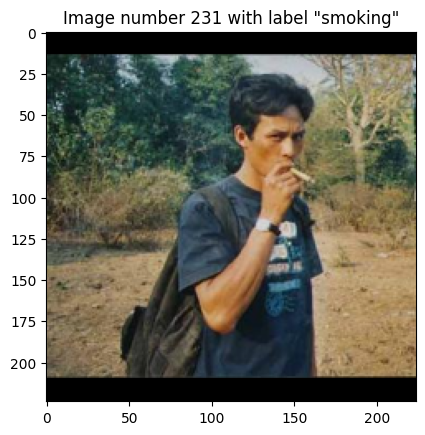

In [118]:
import cv2
from matplotlib import pyplot as plt

image_no = 231  # [0, 1200]
img_rgb = cv2.cvtColor(train_images_resized[image_no], cv2.COLOR_BGR2RGB)
plt.title(f'Image number {image_no} with label "{train_labels_osamp[image_no]}"')
plt.imshow(img_rgb)
plt.show()

## CNN

# Human Motion Database 51 (HMDB51)
### Download the dataset

In [16]:
if DOWNLOAD_HMDB51:
    response_hmdb51_imgs = requests.get("http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar")
    if response_hmdb51_imgs.status_code == 200:
        print("Data download successful")
        os.makedirs("HMDB51", exist_ok=True)
        with open(os.path.join("HMDB51", "hmdb51_org.rar"), "wb") as f:
            f.write(response_hmdb51_imgs.content)
    else:
        print("Data download failed")
        
    response_hmdb51_splits = requests.get("http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar")
    if response_hmdb51_splits.status_code == 200:
        print("Splits download successful")
        os.makedirs("HMDB51", exist_ok=True)
        with open(os.path.join("HMDB51", "test_train_splits.rar"), "wb") as f:
            f.write(response_hmdb51_splits.content)
    else:
        print("Splits download failed")

Data download successful
Splits download successful


### Extract and organize data

In [ ]:
if DOWNLOAD_HMDB51:
    data_path = os.path.join("HMDB51", "video_data")
    data_rar_path = os.path.join("HMDB51", "hmdb51_org.rar")
    splits_path = os.path.join("HMDB51", "test_train_splits")
    splits_rar_path = os.path.join("HMDB51", "test_train_splits.rar")
    os.makedirs(data_path, exist_ok=True)
    os.makedirs(splits_path, exist_ok=True)

    temp_path = os.path.join("HMDB51", "temp")
    os.makedirs(temp_path, exist_ok=True)
    patoolib.extract_archive(splits_rar_path, outdir=temp_path)
    for file in os.listdir(os.path.join(temp_path, "testTrainMulti_7030_splits")):
        src_file_path = os.path.join(temp_path, "testTrainMulti_7030_splits", file)
        dst_file_path = os.path.join(splits_path, file)

        if os.path.exists(dst_file_path):
            print("existed")
            os.remove(dst_file_path)
            shutil.move(src_file_path, dst_file_path)
        else:
            print("not existed")
            shutil.move(src_file_path, dst_file_path)
        
        
    shutil.rmtree(temp_path)
    os.remove(splits_rar_path)      

    patoolib.extract_archive(data_rar_path, outdir=data_path)
    os.remove(data_rar_path)

    keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
            "run", "shoot_bow", "smoke", "throw", "wave"]

    for file in os.listdir(data_path):
        folder_name = file.split(".")[0]
        if folder_name in keep_hmdb51:
            # Extract only the relevant classes
            os.makedirs(os.path.join(data_path, folder_name), exist_ok=True)
            patoolib.extract_archive(os.path.join(data_path, file), outdir=data_path)
        os.remove(os.path.join(data_path, file))

### Split the dataset into train, validation, and test

In [33]:
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
            "run", "shoot_bow", "smoke", "throw", "wave"]

# Train set tagged with ID 1, test set tagged with ID 2
TRAIN_TAG, TEST_TAG = 1, 2
train_val_files, test_files = [], []
train_val_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join("HMDB51", "test_train_splits", split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for file_path in annotation_paths:
    class_name = "_".join(file_path.split(os.sep)[-1].split("_")[:-2])
    if class_name not in keep_hmdb51:
        continue  # Skipping the classes that are not used
    with open(file_path) as fid:
        lines = fid.readlines()
    for line in lines:
        video_file_name, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_val_files.append(video_file_name)
            train_val_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_file_name)
            test_labels.append(class_name)

# 10% of train as validation, no stratification necessary (equal number of videos per class)
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels,
                                                                    test_size=0.1, random_state=0)

print(f"Train + Validation distribution ({len(train_val_files)}):\n{list(Counter(sorted(train_val_labels)).items())}\n")
print("#"*200)
print(f"Train distribution ({len(train_files)}):\n{list(Counter(sorted(train_labels)).items())}\n")
print("#"*200)
print(f"Validation distribution ({len(val_files)}):\n{list(Counter(sorted(val_labels)).items())}\n")
print("#"*200)
print(f"Test distribution  ({len(test_files)}):\n{list(Counter(sorted(test_labels)).items())}\n")
print("#"*200)
action_categories = sorted(list(set(train_val_labels)))
print(f"Action categories ({len(action_categories)}):\n{action_categories}")

output_list_to_file(os.path.join("HMDB51", "train_val_files.txt"), train_val_files)
output_list_to_file(os.path.join("HMDB51", "train_val_labels.txt"), train_val_labels)
output_list_to_file(os.path.join("HMDB51", "train_files.txt"), train_files)
output_list_to_file(os.path.join("HMDB51", "train_labels.txt"), train_labels)
output_list_to_file(os.path.join("HMDB51", "val_files.txt"), val_files)
output_list_to_file(os.path.join("HMDB51", "val_labels.txt"), val_labels)
output_list_to_file(os.path.join("HMDB51", "test_files.txt"), test_files)
output_list_to_file(os.path.join("HMDB51", "test_labels.txt"), test_labels)

Train + Validation distribution (840):
[('clap', 70), ('climb', 70), ('drink', 70), ('jump', 70), ('pour', 70), ('ride_bike', 70), ('ride_horse', 70), ('run', 70), ('shoot_bow', 70), ('smoke', 70), ('throw', 70), ('wave', 70)]

########################################################################################################################################################################################################
Train distribution (756):
[('clap', 65), ('climb', 67), ('drink', 61), ('jump', 58), ('pour', 65), ('ride_bike', 64), ('ride_horse', 63), ('run', 63), ('shoot_bow', 65), ('smoke', 60), ('throw', 64), ('wave', 61)]

########################################################################################################################################################################################################
Validation distribution (84):
[('clap', 5), ('climb', 3), ('drink', 9), ('jump', 12), ('pour', 5), ('ride_bike', 6), ('ride_horse', 7), ('run', 7), ('shoot